## Imports

In [220]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

# # for creating a responsive plot
# %matplotlib ipympl
# %matplotlib widget

import torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

## Data Tokenizer

In [221]:

words = open('names.txt', 'r').read().splitlines()

In [222]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

## Heatmap and Embedding Visualization

In [223]:
import itertools
def plot_heatmap(tensor, text=True, nrow=None, ncol=None, fig_size=(10,10)):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    if text:
        for i, j in itertools.product(range(nrow), range(ncol)):
            # x:col, y:rows, the origin is top left corner, makes bottom <->top
            plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

### 2D & 3d Embedding Visualization

In [224]:
def plot_2d_emb(emb_lkt, nclass, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.scatter(x= emb_lkt[:,0].data, y=emb_lkt[:,1].data, s=200)
    for i in range(nclass):
        plt.text(x=emb_lkt[i,0].item(), y=emb_lkt[i,1].item(), s=i_to_s[i], ha='center', va='center', color='white')
    plt.grid('minor')

# def plot_3d_emb(emb_lkt, nclass, figsize=(8,8)):
#     tensor = emb_lkt.data.detach().numpy()
#     fig = plt.figure(figsize=figsize)
#     ax = Axes3D(fig)
#     ax.scatter(xs= tensor[:,0], ys=tensor[:,1], zs=tensor[:,2], s=200)
#     for i in range(nclass):
#         ax.text(x=tensor[i,0], y=tensor[i,1],z=tensor[i,2], s=i_to_s[i], ha='center', va='center', color='white')
#     # displaying the plot
#     plt.grid('minor')
#     plt.show()

## Splitting dataset into Training Dev & Test sets

1. split rate 80%, 10%, 10%

2. Dev or Validation set is for hyper parameter tuning

3. test should be touched at he end

In [225]:
WINDOW_SIZE = 8
NCLASS = 27
DEVICE = 'cpu' # 'cuda' , 'cpu'

def build_dataset(words:list, type:str):
    xs, ys = [], []

    # context input window: how many characters do we take to predict the next one?
    

    for w in words:
        context_window = [0]*WINDOW_SIZE
        for ch in f'{w}.':
            idx_y = s_to_i[ch]
            ys.append(idx_y)

            xs.append(context_window) # input : ch1
            # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

            # shift_to_left context window and append the idx_y
            context_window = context_window[1:] + [idx_y]
    xs = torch.tensor(xs, device= DEVICE) # device= 'cuda' 
    # ys = torch.Tensor(ys)
    ys = torch.tensor(ys, device= DEVICE)
    print(f'{type}: {xs.shape = }')
    return xs, ys


import random
random.seed(42)
random.shuffle(words)
n80 = int( 0.8*len(words) )
n90 = int( 0.9*len(words) )
Xtr, Ytr = build_dataset(words[:n80], 'Tr')
Xdev, Ydev = build_dataset(words[n80:n90], 'Dev')
Xts, Yts = build_dataset(words[n90:], 'Ts')
TR_SIZE = Xtr.shape[0]
DEV_SIZE = Xdev.shape[0]
TS_SIZE = Xts.shape[0]
print(f'{TR_SIZE = }')
print(f'{WINDOW_SIZE = }')
print(f'{NCLASS = }')

Tr: xs.shape = torch.Size([182625, 8])
Dev: xs.shape = torch.Size([22655, 8])
Ts: xs.shape = torch.Size([22866, 8])
TR_SIZE = 182625
WINDOW_SIZE = 8
NCLASS = 27


# NN from Scratch
In NN architectures we usually have a stack of multiple similar blocks connected together. This block is composed of 3 layers: 

1. Embedding & Flatten

2. Linear or Matrix Multiplication

3. Batch Normalization

4. Activation function

5. Sequential Container

In [226]:
torch.manual_seed(42)

In [227]:
class Module:
    def parameters(self):
        return []

## 1. Embedding & Flatten

In [228]:
class Embedding(Module):
    def __init__(self, nclass:int, emb_dim:int) -> None:
        self.emb_lkt = torch.randn( nclass, emb_dim, device= DEVICE) # device= 'cuda'

    def __call__(self, batch_idx) :
        self.out = self.emb_lkt[batch_idx] # BATCH_SIZE, WINDOW_SIZE, emb_dim
        return self.out
    
    def parameters(self):
        return [self.emb_lkt]


class Flatten(Module):
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return super().parameters()

## 2. Linear Layer

In [229]:
class Linear(Module):
    def __init__(self, fan_in, fan_out, bias=True, w_gain=1.0) -> None:
        # initialization
        self.w_gain = w_gain
        self.W = torch.randn(fan_in, fan_out, device= DEVICE) / fan_in**0.5 # device= 'cuda'
        self.b = torch.zeros(fan_out, device= DEVICE) if bias else None # device= 'cuda'
    
    def __call__(self, x):
        self.out = x @ (self.w_gain * self.W)
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ( [] if self.b is None else [self.b] )

## 3. Batch Normalization Layer

In [230]:
class BatchNorm1d(Module):
    def __init__(self, fan_out, eps=1e-5, momentum=0.01, scale_gain=1.0, training=True) -> None:
        self.eps = eps
        self.momentum = momentum

        # flexible Gaussian preact
        self.scale = torch.ones(fan_out, device= DEVICE) # device= 'cuda'
        self.shift = torch.zeros(fan_out, device= DEVICE) # device= 'cuda'

        # use it just in case you want to use batch norm as logits before loss
        self.scale_gain = scale_gain

        self.training = training

        # Buffers (in PyTorch nomenclature)
        # ema of mean and std
        self.bn_mean_ema = torch.zeros(fan_out, device= DEVICE) # device= 'cuda'
        self.bn_std_ema = torch.ones(fan_out, device= DEVICE) # device= 'cuda'
    
    def __call__(self, x):
        if self.training:
            self.bn_mean = x.mean(dim=0, keepdim=True) # 1, HLAYER_SIZE
            self.bn_std = x.std(dim=0, keepdim=True) # 1, HLAYER_SIZE
            self.out = self.shift + self.scale_gain * self.scale * (x - self.bn_mean) / (self.bn_std + self.eps)

            # update moving stats
            with torch.no_grad():
                self.bn_mean_ema = (1 - self.momentum) * self.bn_mean_ema + self.momentum * self.bn_mean
                self.bn_std_ema = (1 - self.momentum) * self.bn_std_ema + self.momentum * self.bn_std
        else:
            with torch.no_grad():
                self.out = self.shift + self.scale * (x - self.bn_mean_ema) / (self.bn_std_ema + self.eps)
        return self.out
    
    def parameters(self):
        return [self.scale, self.shift]

## 4. Activation Function

In [231]:
class Tanh(Module):

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

## 5. Sequential Container

In [232]:
class Sequential(Module):
    def __init__(self, layers) -> None:
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def append(self, layer):
        self.layers.append(layer)

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## Building model Sequentially

In [233]:
EMB_DIM = 7
HLAYER_SIZE = 250
DIVISION0 = 0.001

# MLP layers with Batch Norm
model = Sequential([
    Embedding(nclass=NCLASS, emb_dim=EMB_DIM),
    Flatten(),
    
    Linear(fan_in=WINDOW_SIZE*EMB_DIM, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),

    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
    
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
    
    Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
])

# The recommended Gain for weight initialization of all
# Motif Blocks based on the activation
for layer in model.layers:
    if isinstance(layer, Linear):
        layer.w_gain = 5/3
    elif isinstance(layer, BatchNorm1d):
        layer.training = True

# add logits layer with low weight gain to make it less confident
model.append(Linear(fan_in=HLAYER_SIZE, fan_out=NCLASS, bias=True, w_gain=0.1) )

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

210466

In [234]:
BATCH_SIZE = 32
NITERS = 110000

DEBUG_ITERS = 1

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []
upd_param_ratio = []

for layer in model.layers:
    if isinstance(layer, Linear):
        layer.w_gain = 5/3
    elif isinstance(layer, BatchNorm1d):
        layer.training = True

for iter in range(NITERS):
    
    # Mini batch construct
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,), device= DEVICE) # device= 'cuda'
    x= Xtr[mini_batch_idx]
    
    # Forward pass
    logits = model(x)
    
    batch_loss = F.cross_entropy(logits, Ytr[mini_batch_idx])
    lossi.append(batch_loss.log10().item())
    stepi.append(iter)

    # Backward pass
    for layer in model.layers:
        # keep track of grads for DEBUGGING
        layer.out.retain_grad() # AFTER DEDBUG: would take out retain_grad

    for p in model.parameters():
        p.grad = None
    batch_loss.backward()

    # update &
    lr = 0.1 if iter < 100000 else 0.01
    for p in model.parameters():
        p.data -= lr*p.grad
        # p.grad = None
    
    with torch.no_grad():
        upd_param_ratio.append( [(lr*p.grad.std() / p.data.std()).item() for p in parameters ] ) # DEBUG_ITERS * NPARAMS
    
    # track stats
    if iter % 10000 == 0:
        print(f'iteration: {iter:7d} / {NITERS:7d} | mini loss: {batch_loss.item():.4f}')
    
    if iter > DEBUG_ITERS: 
        break # intentionally added, AFTER DEBUG, would take out obviously to run full optimization


iteration:       0 /  110000 | mini loss: 3.9337


## WaveNet Embedding

let's see something surprising about Matrix Multiplication in PyTorch:

In [235]:
# btchsz = 4
# wndwsz = 8
# embsz = 10

# ix = torch.randint(low=0, high=TR_SIZE, size=(btchsz,))
# x, y = Xtr[ix], Ytr[ix]


In [236]:
print(BATCH_SIZE, WINDOW_SIZE, EMB_DIM)
print(HLAYER_SIZE)
print(model.layers[0].out.shape)
print(model.layers[1].out.shape)
print(model.layers[2].out.shape)

32 8 7
250
torch.Size([32, 8, 7])
torch.Size([32, 56])
torch.Size([32, 250])


Above is just the Embedding Flatten & Linear layers:

The Matrix shape does not have to be 2D!!

Reading the link below is a must!!!
https://pytorch.org/docs/stable/generated/torch.matmul.html


we have batch dimensions and matrix dimensions.

for a Matrix Multiplication (MM):

    - matrix dimensions: the first 2 or 1 dimensions from right. they must obey the MM rule (same operation dimension) : (n, m) @ (m, p) -> (n, p)

    - batch dimensions: other dimensions, must be broadcastable

    - For example, if input is a (j×1×n×n) tensor and other is a (k×n×n) tensor, we have size mismatch, the first 2 dimensions from right in each matrix are the matrix dimensions, and others are batch dimensions. out will be a (j×k×n×n) tensor. in fact the matrix multiplication is done on the feature (matrix) dimensions

    - For example, if input is a (j×1×n×m) tensor and other is a (k×m×p) tensor, these inputs are valid for broadcasting even though the final two dimensions (i.e. the matrix dimensions) are different. out will be a (j×k×n×p) tensor.

    - For example, if input is a (j×1×m) tensor and other is a (k×m) tensor, these inputs are valid for broadcasting. out will be a (j×k×m) tensor.

In [237]:
eflat = torch.randn(BATCH_SIZE, 4, WINDOW_SIZE*EMB_DIM)
print(eflat.shape)
w = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE)
print(w.shape)
(eflat @ w).shape

torch.Size([32, 4, 56])
torch.Size([56, 250])


torch.Size([32, 4, 250])

Now we can use it for our WaveNet Network:

- instead of flattening all characters in a sample into a long vector, let's create hierarchy of embeddings by grouping them in pairs or triples, and process them in parallel.

[112233445566] -> shape: ( 1 , 6x2 ) or BS , WINDOW_SIZE x EMB_DIM

emb1: 11

[(1122)(3344)(5566)] -> shape: (1, 6/2 , 2x2 )

1 : 1st batch dimension

6/2: 2nd batch dimension

**`But we wanna halve the 2nd batch dimension by pairing adjacent embeddings not by dividing from the middle!!!`**

In [238]:
e = torch.randn(BATCH_SIZE, WINDOW_SIZE, EMB_DIM)
print(e.shape)
# int division : //
e_grouped_flat = e.view((BATCH_SIZE, WINDOW_SIZE//2, 2*EMB_DIM) )
print(e_grouped_flat.shape)
w = torch.randn( 2*EMB_DIM, HLAYER_SIZE)
print(w.shape)
(e_grouped_flat @ w).shape

torch.Size([32, 8, 7])
torch.Size([32, 4, 14])
torch.Size([14, 250])


torch.Size([32, 4, 250])

In [239]:
# even better!!
e = torch.randn(BATCH_SIZE, 8, EMB_DIM)
e_halved_flat = e.view(BATCH_SIZE, -1, 2*EMB_DIM)
print(e_halved_flat.shape)

torch.Size([32, 4, 14])


In [240]:
# get the even or odd elements
print(list(range(10))[::2])
print(list(range(10))[1::2])

[0, 2, 4, 6, 8]
[1, 3, 5, 7, 9]


In [241]:
e = torch.randn(BATCH_SIZE, WINDOW_SIZE, EMB_DIM)
print(e.shape)
# ! this way of way of halving is implicitly pairing adjacent!!!!
e_halved_flat = e.view(BATCH_SIZE, WINDOW_SIZE//2, 2*EMB_DIM)
print(e_halved_flat.shape)
# ! this way of way of halving is explicitly pairing adjacent!!!
e_grouped_flat = torch.cat( [e[:, ::2 , :], e[:, 1::2 , :] ], dim=2 ) # dim = 2 flat the emb
print(e_grouped_flat.shape)

# * surprisingly these 2 are equal !!
(e_halved_flat == e_grouped_flat).all()

torch.Size([32, 8, 7])
torch.Size([32, 4, 14])
torch.Size([32, 4, 14])


tensor(True)

## Defining GroupConsecutive class

In [242]:
class GroupConsecutive(Module):
    def __init__(self, group_size) -> None:
        self.group_size = group_size
    
    def __call__(self, x):
        B, W, E = x.shape
        x = x.view(B, W//self.group_size, E*self.group_size)
        # * we also wanna be able to do simple Flatten
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out
    
    def parameters(self):
        return super().parameters()

## building the model again

1. We have a sliding window of characters or words with WINDOW_SIZE=8 characters (must be a power of 2). Each word is a vector with the size of EMB_DIM=2. We create a 2D input by grouping (concatenating) embeddings. the Number of Embeddings at each Group is 2, meaning we have WINDOW_SIZE/N_IN_GROUP = 4 groups

2. In the 1st linear layer, for each pair or group of embeddings there is a specific 1D FC layer with desired size = 250, therefore in total, there are 4 of this 1D FC layer, layer fan_out=(4,250)

3. After this layer, again we have a pairing or grouping, but this time instead of embeddings, we group (concatinate) the two 1D FC layers of hidden layer.

4. this continues 2D layer by layer like the World Cup till we reach final. WINDOW_SIZE=8 must be a power of 2 and the power determines the depth = 3 of the NN.

In [243]:
EMB_DIM = 2
N_IN_GROUP = 2
HLAYER_SIZE = 250
DIVISION0 = 0.001

# MLP layers with Batch Norm
model = Sequential([
    Embedding(nclass=NCLASS, emb_dim=EMB_DIM),
    
    GroupConsecutive(group_size=N_IN_GROUP), # if group_size = WINDOW_SIZE should have the same result
    Linear(fan_in=N_IN_GROUP*EMB_DIM, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),

    GroupConsecutive(group_size=N_IN_GROUP),
    Linear(fan_in=N_IN_GROUP*HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
    
    GroupConsecutive(group_size=N_IN_GROUP),
    Linear(fan_in=N_IN_GROUP*HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
    
    # GroupConsecutive(group_size=N_IN_GROUP),
    # Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    # BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    # Tanh(),
])

# The recommended Gain for weight initialization of all
# Motif Blocks based on the activation
for layer in model.layers:
    if isinstance(layer, Linear):
        layer.w_gain = 5/3
    elif isinstance(layer, BatchNorm1d):
        layer.training = True

# add logits layer with low weight gain to make it less confident
model.append(Linear(fan_in=HLAYER_SIZE, fan_out=NCLASS, bias=True, w_gain=0.1) )

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

259331

In [244]:
BATCH_SIZE = 32
NITERS = 110000

DEBUG_ITERS = 1

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []
upd_param_ratio = []

for layer in model.layers:
    if isinstance(layer, Linear):
        layer.w_gain = 5/3
    elif isinstance(layer, BatchNorm1d):
        layer.training = True

for iter in range(NITERS):
    
    # Mini batch construct
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,), device= DEVICE) # device= 'cuda'
    x= Xtr[mini_batch_idx]
    
    # Forward pass
    logits = model(x)
    
    batch_loss = F.cross_entropy(logits, Ytr[mini_batch_idx])
    lossi.append(batch_loss.log10().item())
    stepi.append(iter)

    # Backward pass
    for layer in model.layers:
        # keep track of grads for DEBUGGING
        layer.out.retain_grad() # AFTER DEDBUG: would take out retain_grad

    for p in model.parameters():
        p.grad = None
    batch_loss.backward()

    # update &
    lr = 0.1 if iter < 100000 else 0.01
    for p in model.parameters():
        p.data -= lr*p.grad
        # p.grad = None
    
    with torch.no_grad():
        upd_param_ratio.append( [(lr*p.grad.std() / p.data.std()).item() for p in parameters ] ) # DEBUG_ITERS * NPARAMS
    
    # track stats
    if iter % 10000 == 0:
        print(f'iteration: {iter:7d} / {NITERS:7d} | mini loss: {batch_loss.item():.4f}')
    
    if iter > DEBUG_ITERS: 
        break # intentionally added, AFTER DEBUG, would take out obviously to run full optimization


iteration:       0 /  110000 | mini loss: 3.5119


In [245]:
for layer in model.layers:
    print(layer.__class__.__name__, ':')
    if isinstance(layer, Linear):
        print(f'{layer.W.shape=}')
    # elif isinstance(layer, BatchNorm1d):
    #     layer.training = True
    print(f'{layer.out.shape=}\n')

Embedding :
layer.out.shape=torch.Size([32, 8, 2])

GroupConsecutive :
layer.out.shape=torch.Size([32, 4, 4])

Linear :
layer.W.shape=torch.Size([4, 250])
layer.out.shape=torch.Size([32, 4, 250])

BatchNorm1d :
layer.out.shape=torch.Size([32, 4, 250])

Tanh :
layer.out.shape=torch.Size([32, 4, 250])

GroupConsecutive :
layer.out.shape=torch.Size([32, 2, 500])

Linear :
layer.W.shape=torch.Size([500, 250])
layer.out.shape=torch.Size([32, 2, 250])

BatchNorm1d :
layer.out.shape=torch.Size([32, 2, 250])

Tanh :
layer.out.shape=torch.Size([32, 2, 250])

GroupConsecutive :
layer.out.shape=torch.Size([32, 500])

Linear :
layer.W.shape=torch.Size([500, 250])
layer.out.shape=torch.Size([32, 250])

BatchNorm1d :
layer.out.shape=torch.Size([32, 250])

Tanh :
layer.out.shape=torch.Size([32, 250])

Linear :
layer.W.shape=torch.Size([250, 27])
layer.out.shape=torch.Size([32, 27])



## Fixing Batch Norm
The batch norm layer were computing the mean and std of samples bc of dim=0, and it was bc the batch and layers were 1D.

but now we have 2 batch dimensions and 2D layers, dim=0 the does not consider the 2nd batch dimension (values in other groups)

we can easily specify a tuple of dim instead of int:

In [246]:
prebn = torch.randn(32, WINDOW_SIZE//N_IN_GROUP, HLAYER_SIZE)
print(prebn.shape)
bn_mean = prebn.mean(dim=0, keepdim=True) # 1, HLAYER_SIZE
print(bn_mean.shape)
bn_std = prebn.std(dim=0, keepdim=True) # 1, HLAYER_SIZE
print(bn_std.shape)
bn_raw = (prebn - bn_mean) / (bn_std + 1e-5)
print(prebn.shape)

torch.Size([32, 4, 250])
torch.Size([1, 4, 250])
torch.Size([1, 4, 250])
torch.Size([32, 4, 250])


In [247]:
bn_mean = prebn.mean(dim=(0,1), keepdim=True) # 1, HLAYER_SIZE
print(bn_mean.shape)
bn_std = prebn.std(dim=(0,1), keepdim=True) # 1, HLAYER_SIZE
print(bn_std.shape)
bn_raw = (prebn - bn_mean) / (bn_std + 1e-5)
print(prebn.shape)

torch.Size([1, 1, 250])
torch.Size([1, 1, 250])
torch.Size([32, 4, 250])


### Modifying Batch Norm

In [248]:
class BatchNorm1d(Module):
    def __init__(self, fan_out, eps=1e-5, momentum=0.01, scale_gain=1.0, training=True) -> None:
        self.eps = eps
        self.momentum = momentum

        # flexible Gaussian preact
        self.scale = torch.ones(fan_out, device= DEVICE) # device= 'cuda'
        self.shift = torch.zeros(fan_out, device= DEVICE) # device= 'cuda'

        # use it just in case you want to use batch norm as logits before loss
        self.scale_gain = scale_gain

        self.training = training

        # Buffers (in PyTorch nomenclature)
        # ema of mean and std
        self.bn_mean_ema = torch.zeros(fan_out, device= DEVICE) # device= 'cuda'
        self.bn_std_ema = torch.ones(fan_out, device= DEVICE) # device= 'cuda'
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim ==3:
                dim = (0,1)
            self.bn_mean = x.mean(dim=dim, keepdim=True) # 1, HLAYER_SIZE
            self.bn_std = x.std(dim=dim, keepdim=True) # 1, HLAYER_SIZE
            self.out = self.shift + self.scale_gain * self.scale * (x - self.bn_mean) / (self.bn_std + self.eps)

            # update moving stats
            with torch.no_grad():
                self.bn_mean_ema = (1 - self.momentum) * self.bn_mean_ema + self.momentum * self.bn_mean
                self.bn_std_ema = (1 - self.momentum) * self.bn_std_ema + self.momentum * self.bn_std
        else:
            with torch.no_grad():
                self.out = self.shift + self.scale * (x - self.bn_mean_ema) / (self.bn_std_ema + self.eps)
        return self.out
    
    def parameters(self):
        return [self.scale, self.shift]

In [249]:
EMB_DIM = 5
N_IN_GROUP = 2
HLAYER_SIZE = 100
DIVISION0 = 0.001

# MLP layers with Batch Norm
model = Sequential([
    Embedding(nclass=NCLASS, emb_dim=EMB_DIM),
    
    GroupConsecutive(group_size=N_IN_GROUP), # if group_size = WINDOW_SIZE should have the san=me result
    Linear(fan_in=N_IN_GROUP*EMB_DIM, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),

    GroupConsecutive(group_size=N_IN_GROUP),
    Linear(fan_in=N_IN_GROUP*HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
    
    GroupConsecutive(group_size=N_IN_GROUP),
    Linear(fan_in=N_IN_GROUP*HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    Tanh(),
    
    # GroupConsecutive(group_size=N_IN_GROUP),
    # Linear(fan_in=HLAYER_SIZE, fan_out=HLAYER_SIZE, bias=False),
    # BatchNorm1d(fan_out=HLAYER_SIZE, eps=1e-5, momentum=DIVISION0),
    # Tanh(),
])

# The recommended Gain for weight initialization of all
# Motif Blocks based on the activation
for layer in model.layers:
    if isinstance(layer, Linear):
        layer.w_gain = 5/3
    elif isinstance(layer, BatchNorm1d):
        layer.training = True

# add logits layer with low weight gain to make it less confident
model.append(Linear(fan_in=HLAYER_SIZE, fan_out=NCLASS, bias=True, w_gain=0.1) )

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

44462

In [250]:
BATCH_SIZE = 32
NITERS = 110000

DEBUG_ITERS = 1

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []
upd_param_ratio = []

for layer in model.layers:
    if isinstance(layer, Linear):
        layer.w_gain = 5/3
    elif isinstance(layer, BatchNorm1d):
        layer.training = True

for iter in range(NITERS):
    
    # Mini batch construct
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,), device= DEVICE) # device= 'cuda'
    x= Xtr[mini_batch_idx]
    
    # Forward pass
    logits = model(x)
    
    batch_loss = F.cross_entropy(logits, Ytr[mini_batch_idx])
    lossi.append(batch_loss.log10().item())
    stepi.append(iter)

    # Backward pass
    for layer in model.layers:
        # keep track of grads for DEBUGGING
        layer.out.retain_grad() # AFTER DEDBUG: would take out retain_grad

    for p in model.parameters():
        p.grad = None
    batch_loss.backward()

    # update &
    lr = 0.1 if iter < 100000 else 0.01
    for p in model.parameters():
        p.data -= lr*p.grad
        # p.grad = None
    
    with torch.no_grad():
        upd_param_ratio.append( [(lr*p.grad.std() / p.data.std()).item() for p in parameters ] ) # DEBUG_ITERS * NPARAMS
    
    # track stats
    if iter % 10000 == 0:
        print(f'iteration: {iter:7d} / {NITERS:7d} | mini loss: {batch_loss.item():.4f}')
    
    if iter > DEBUG_ITERS: 
        break # intentionally added, AFTER DEBUG, would take out obviously to run full optimization


iteration:       0 /  110000 | mini loss: 3.6840


In [251]:
for layer in model.layers:
    print(layer.__class__.__name__, ':')
    if isinstance(layer, Linear):
        print(f'{layer.W.shape=}')
    elif isinstance(layer, BatchNorm1d):
        print(f'{layer.bn_mean.shape=}')
    print(f'{layer.out.shape=}\n')

Embedding :
layer.out.shape=torch.Size([32, 8, 5])

GroupConsecutive :
layer.out.shape=torch.Size([32, 4, 10])

Linear :
layer.W.shape=torch.Size([10, 100])
layer.out.shape=torch.Size([32, 4, 100])

BatchNorm1d :
layer.bn_mean.shape=torch.Size([1, 1, 100])
layer.out.shape=torch.Size([32, 4, 100])

Tanh :
layer.out.shape=torch.Size([32, 4, 100])

GroupConsecutive :
layer.out.shape=torch.Size([32, 2, 200])

Linear :
layer.W.shape=torch.Size([200, 100])
layer.out.shape=torch.Size([32, 2, 100])

BatchNorm1d :
layer.bn_mean.shape=torch.Size([1, 1, 100])
layer.out.shape=torch.Size([32, 2, 100])

Tanh :
layer.out.shape=torch.Size([32, 2, 100])

GroupConsecutive :
layer.out.shape=torch.Size([32, 200])

Linear :
layer.W.shape=torch.Size([200, 100])
layer.out.shape=torch.Size([32, 100])

BatchNorm1d :
layer.bn_mean.shape=torch.Size([1, 100])
layer.out.shape=torch.Size([32, 100])

Tanh :
layer.out.shape=torch.Size([32, 100])

Linear :
layer.W.shape=torch.Size([100, 27])
layer.out.shape=torch.Size

## Evaluation

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(dim=1) )

RuntimeError: shape '[-1, 1000]' is invalid for input of size 3

In [ ]:
@torch.no_grad()
def evaluate_loss(ds_type, with_batchN = False): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]
    
    for layer in model.layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
    
    # Forward pass
    logits = model(X)
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')

In [ ]:
# rolling mean and std are almost equal to the exact value
@torch.no_grad()
def compare_ema():
    
    x = Xtr

    for layer in model.layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
    
    for i, layer in enumerate(model.layers):
        print(f'layer {i}: {layer.__class__.__name__}')
        x = layer(x)
        if isinstance(layer, BatchNorm1d):
            bn_mean = x.mean(dim=0, keepdim=True)
            bn_std = x.std(dim=0, keepdim=True)
            print((bn_mean - layer.bn_mean_ema).mean(), (bn_mean - layer.bn_mean_ema).std() )
            print((bn_std - layer.bn_std_ema).mean(), (bn_std - layer.bn_std_ema).std() )

# going into local scale parameters to not change the global ones
compare_ema()

layer 0: Embedding
layer 1: Flatten
layer 2: Linear
layer 3: BatchNorm1d
tensor(-0.2789) tensor(2.0329)
tensor(-0.7237) tensor(0.2084)
layer 4: Tanh
layer 5: Linear
layer 6: BatchNorm1d
tensor(-0.0256) tensor(0.4329)
tensor(-2.4826) tensor(0.4554)
layer 7: Tanh
layer 8: Linear
layer 9: BatchNorm1d
tensor(0.0749) tensor(0.4813)
tensor(-2.6026) tensor(0.4941)
layer 10: Tanh
layer 11: Linear
layer 12: BatchNorm1d
tensor(-0.0207) tensor(0.4255)
tensor(-2.2144) tensor(1.6005)
layer 13: Tanh
layer 14: Linear


if the difference in any layer is higher than 0.5 we need a lower momentum

In [ ]:
evaluate_loss('train', with_batchN=True)
evaluate_loss('dev', with_batchN=True)

train loss: 1.8059988021850586
dev loss: 2.0022337436676025


## Distro Visualization

layer 0: Linear | mean : -0.02 | std : 2.08
layer 3: Linear | mean : 0.05 | std : 3.77
layer 6: Linear | mean : -0.01 | std : 3.63
layer 9: Linear | mean : 0.01 | std : 3.17
layer 12: Linear | mean : -0.18 | std : 6.89


Text(0.5, 1.0, 'Linear pre-activation Distributions')

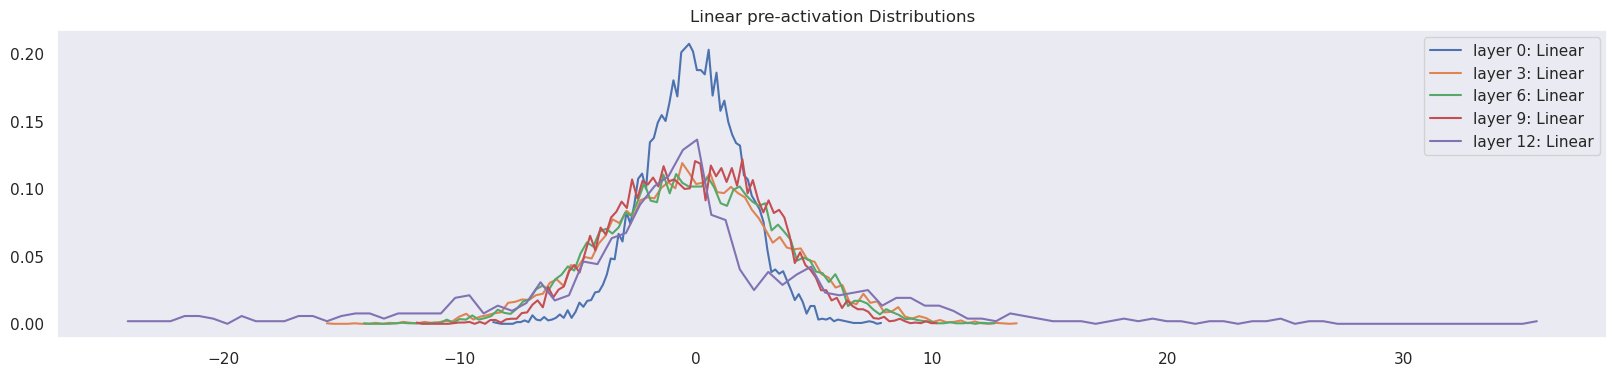

In [90]:
# visualize the Linear pre-activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(model.layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f}')

        hy, hx = torch.histogram(t.cpu(), density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Linear pre-activation Distributions')

layer 1: BatchNorm1d | mean : 0.01 | std : 1.38
layer 4: BatchNorm1d | mean : 0.02 | std : 1.50
layer 7: BatchNorm1d | mean : -0.02 | std : 1.50
layer 10: BatchNorm1d | mean : -0.00 | std : 1.44


Text(0.5, 1.0, 'Batch Norm output Distributions')

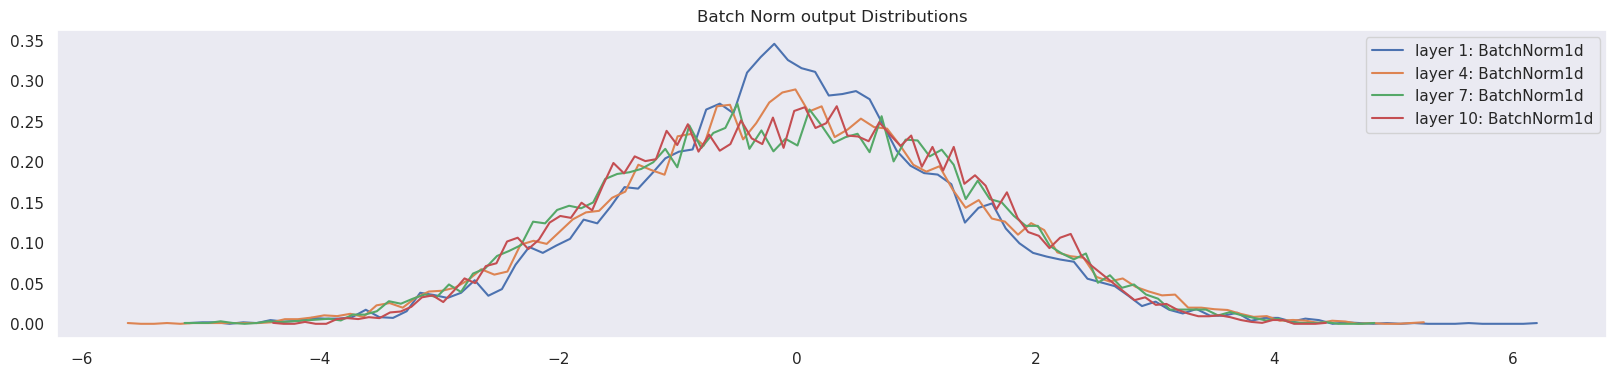

In [91]:
# visualize the Batch Norm output distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, BatchNorm1d):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f}')

        hy, hx = torch.histogram(t.cpu(), density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Batch Norm output Distributions')

layer 2: Tanh | mean : 0.01 | std : 0.70 | saturated : 13.39
layer 5: Tanh | mean : 0.00 | std : 0.73 | saturated : 16.98
layer 8: Tanh | mean : -0.01 | std : 0.75 | saturated : 16.70
layer 11: Tanh | mean : 0.00 | std : 0.74 | saturated : 15.21


Text(0.5, 1.0, 'Activation Distributions')

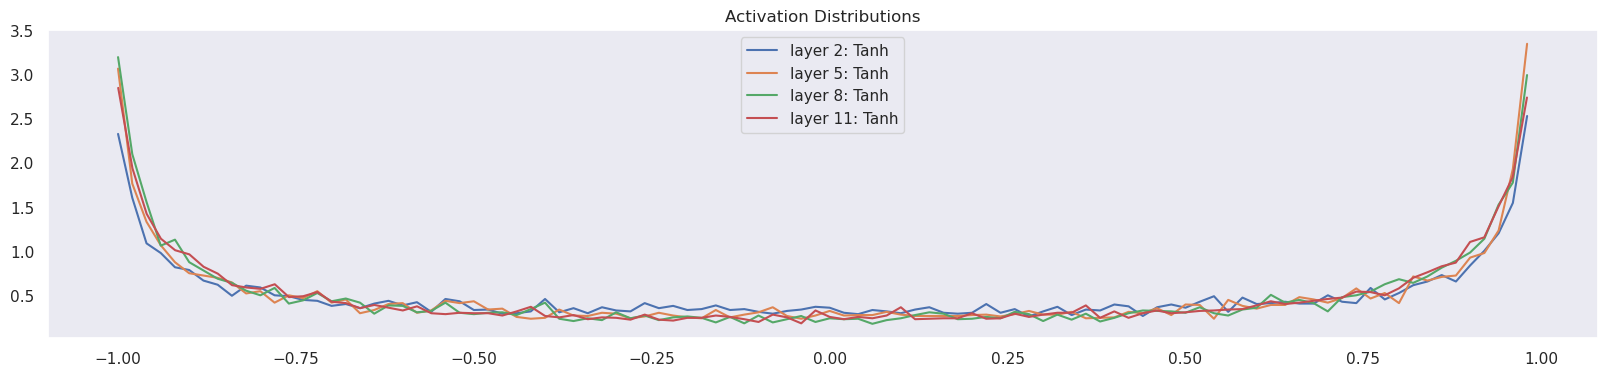

In [92]:
# visualize the Activation distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.2f} | std : {t.std():.2f} | saturated : {(t.abs() > 0.97).float().mean()*100:.2f}')

        hy, hx = torch.histogram(t.cpu(), density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Distributions')

Woow!!, without BatchNorm, after 1K iteration, we had around 20-30% saturated neurons

But now with Batch Norm, we only have 2-3 % of those. 10 x improvement with same std

layer 0: Linear | mean : -0.00000000 | std : 0.00076491
layer 3: Linear | mean : 0.00000000 | std : 0.00041448
layer 6: Linear | mean : -0.00000000 | std : 0.00039761
layer 9: Linear | mean : -0.00000000 | std : 0.00033719
layer 12: Linear | mean : -0.00000000 | std : 0.00077385


Text(0.5, 1.0, 'Activation Gradient Distributions')

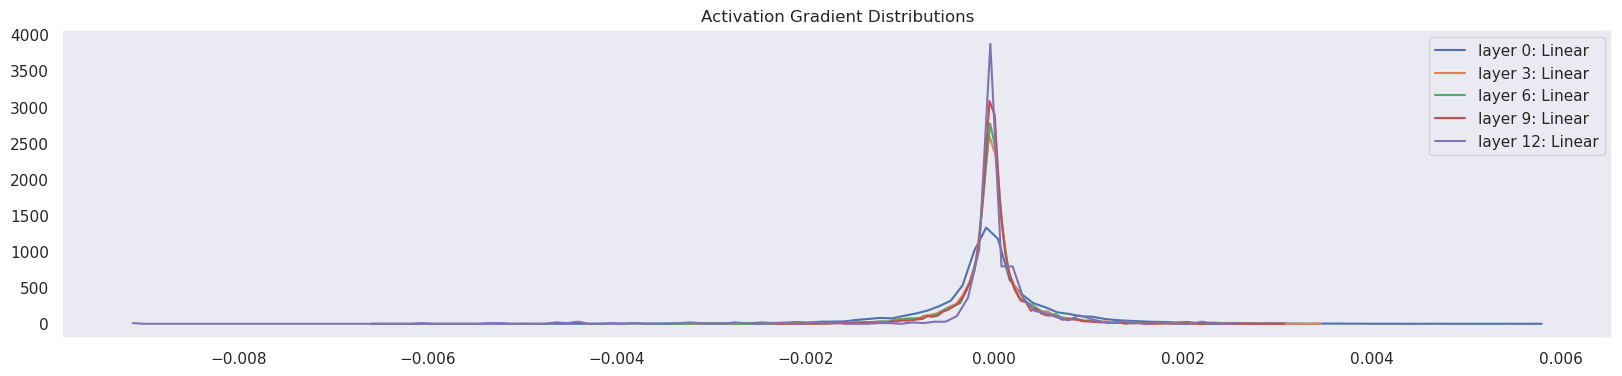

In [93]:
# visualize the Activation Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the logits layer
    if isinstance(layer, Linear):
        t = layer.out.grad # remember when we called retain_grad
        print(f'layer {i}: {layer.__class__.__name__} | mean : {t.mean():.8f} | std : {t.std():.8f}')

        hy, hx = torch.histogram(t.cpu(), density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Gradient Distributions')


weight: (27, 5) | grad mean : 0.00000000 | grad std : 0.01805031 | grad:data ratio : 0.015676869079470634
weight: (25, 300) | grad mean : -0.00001205 | grad std : 0.00622108 | grad:data ratio : 0.023585066199302673
weight: (300, 300) | grad mean : -0.00001138 | grad std : 0.00269956 | grad:data ratio : 0.027454759925603867
weight: (300, 300) | grad mean : 0.00001822 | grad std : 0.00272001 | grad:data ratio : 0.02788405679166317
weight: (300, 300) | grad mean : 0.00001165 | grad std : 0.00235336 | grad:data ratio : 0.026250647380948067
weight: (300, 27) | grad mean : 0.00002256 | grad std : 0.00563778 | grad:data ratio : 0.030366238206624985


Text(0.5, 1.0, 'Parameters Gradient Distributions')

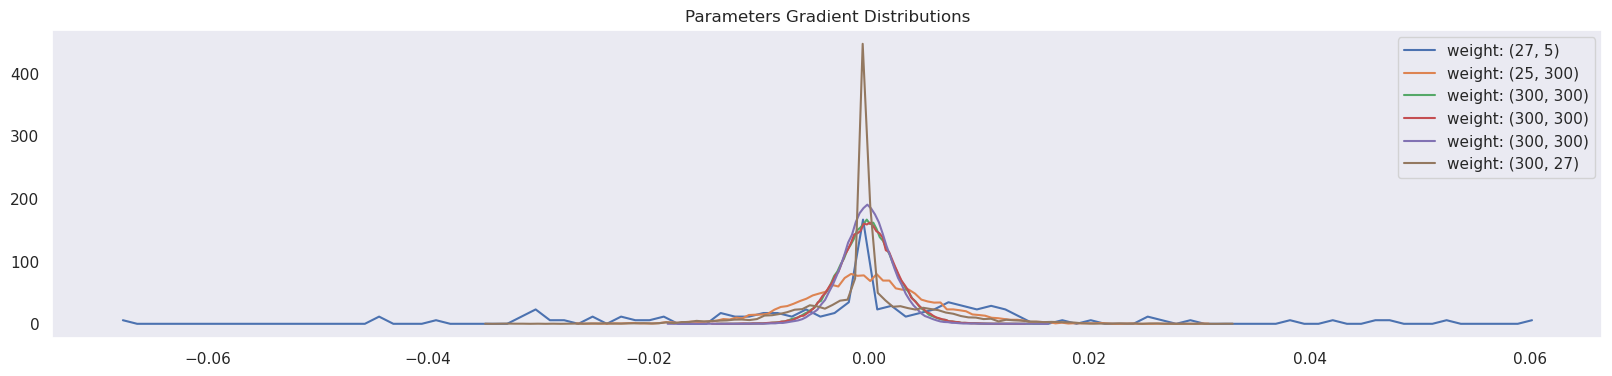

In [94]:
# visualize the parameter Gradient distributions
plt.figure(figsize=(20, 4))
legends = []

for p in parameters:
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        t = p.grad
        '''
        (gradient std) / (data std):
        gives you a sense of what is the range or scale of
        the gradient compared to the range or scale of the
        actual parameters, and it's important bc
        we're going to update the parameters with the gradients
        so we wanna the steps are large, enough or small
        '''
        print(f'weight: {tuple(p.shape)} | grad mean : {t.mean():.8f} | grad std : {t.std():.8f} | grad:data ratio : {t.std()/p.std()}')

        hy, hx = torch.histogram(t.cpu(), density=False)

        plt.plot(hx[:-1].detach(), (hy/hy.sum()).detach())
        legends.append(f'weight: {tuple(p.shape)}')
plt.legend(legends)
plt.title('Parameters Gradient Distributions')

Now we also have better similar parameter grad / data & update/data ratio in different layers, so no faster training fpr one layer

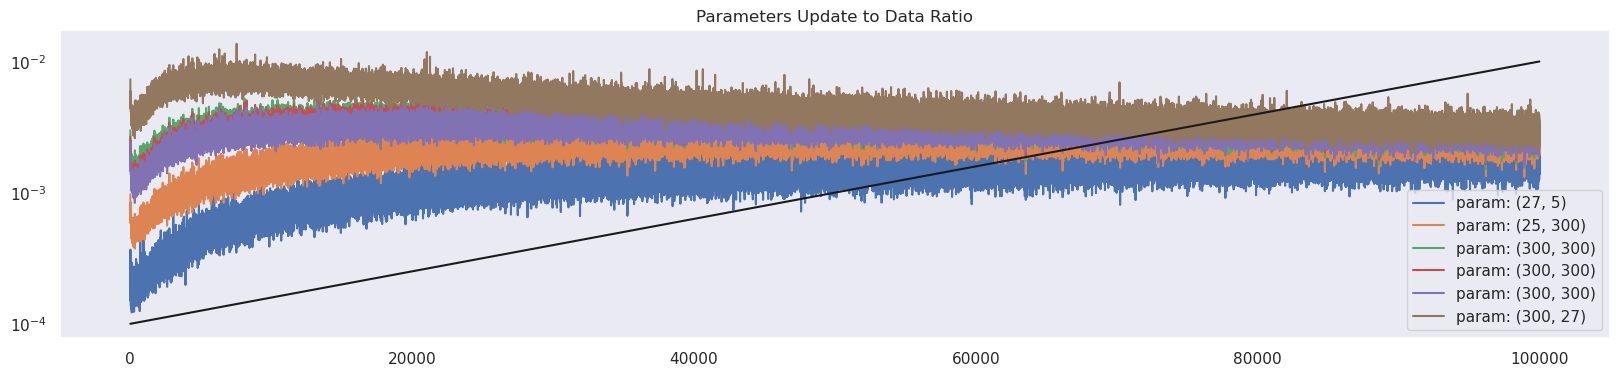

In [95]:
# visualize the update to parameters ratio
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
     # for simpilicity, just looking at 2d parameters meaning W in Linear
     # so skip bias, bn_shift, bn_scale
    if p.ndim == 2:
        # NITERS * NPARAMS
        plt.semilogy( [upd_param_ratio[j][i] for j in range(DEBUG_ITERS)] )
        legends.append(f'param: {tuple(p.shape)}')
plt.semilogy([0, DEBUG_ITERS], [1e-4, 1e-2], 'k') # these ratios should be around ~1e-3, plot this black line to indicate on plot
plt.legend(legends)
plt.title('Parameters Update to Data Ratio')
plt.show()

The recommended update to data ratio for parameters is around 1e-3

if it was 0.1, it means the weights are undergoing a relatively large change.

The reason the last layer (logits) has a larger update ratio is that we had shrunk down the parameter data manually by 0.1 factor, but still the update ratio is below 0.01 and it's decreasing.

if the ratio is below 1e-3 it means that the parameters are not learning fast enough.

Try some miscalibration scenarios like wrong gain and see the plots and compare it with a calibrated one

Now, if you change the weight gains in linear layers none of the above plots would change drastically, except update / data ratio. 

This means **`you still better off keep the recommended weight initialization to have a roughly equal training speed among all layers or adjust the learning rate consequently to have 1e-3 ratio for all layers`**.

But we are way more robust in training even if we change the gain and eliminate the root2(fan-in)

## Hyperparameter Tuning

1- if the training loss is roughly equal (.2f) to the dev loss, it means the model is under-fitted. it's not big enough to just purely memorizes the data. so we can scale the model and increase the number of parameters, meaning the size of hidden layer and embeddings.

2- On the other side, if your overfitting to traing data set, it means the model is to big and over-parameterized. so you have 2 options find a larger dataset, or lower the number of parameters.

Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [15]:
EMB_DIM = 3
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

10881

### increasing the size of Embeddings
Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [50]:
lri = []
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

BATCH_SIZE = 32
loglossi = []
stepi = []

NITERS = 10000

for i in range(NITERS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    
    loglossi.append(loss_mini.log10().item())
    stepi.append(i)

    lr = exponential_lr[i]
    lri.append(lr_expo[i]) # store the exponent

    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # print(f'iteration: {i} | loss: {loss.item()}')

print(f'loss_mini: {loss_mini.item()}')

loss_mini: 1.905316710472107


In [ ]:
evaluate_loss('train')
evaluate_loss('dev')

In [ ]:
plt.plot(lri, loglossi)

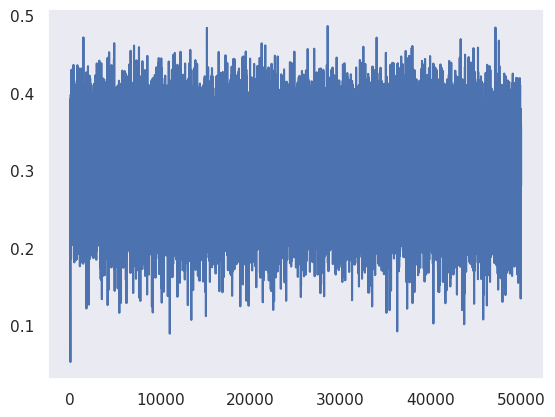

In [51]:
plt.plot(stepi, loglossi)

## Let's Generate some samples like Bigram

In [20]:
for _ in range(10):
    idx_y = 0
    name = ''
    context_window = [0]*WINDOW_SIZE
    
    while True:
        # Forward path

        for layer in model.layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
        
        logits = model(torch.tensor([context_window]))
        qs = F.softmax(logits, dim=1)
        
        idx_y = torch.multinomial(qs.detach(), num_samples=1, replacement=True).item()
        # shift_to_left context window and append the idx_y
        context_window = context_window[1:] + [idx_y]
        if idx_y == 0:
            break
        ch = i_to_s[idx_y]
        # print(ch)
        name += ch
    print(name)

codry
emylynn
lymyah
elin
manyaen
romi
journohemia
joari
eama
griffir
